# MNIST image manipulation

This notebook contains some functions for synthesizing data from MNIST dataset.

Let's include all the necessary libs first and read data.

**IMPORTANT**: in this example train/test data are without header row, so we shouldn't skip it.

In [60]:
import numpy as np
import pandas as pd
import random
import scipy.ndimage as nd
import matplotlib.pyplot as plt

IMAGE_SIZE = 28

train_data = pd.read_csv("./data/train.csv", header=None)

Let's start from rotations and shearing (both suggested in ["Handwritten Digit Recognition with a Committee of
Deep Neural Nets on GPUs"](https://arxiv.org/pdf/1103.4487.pdf)).

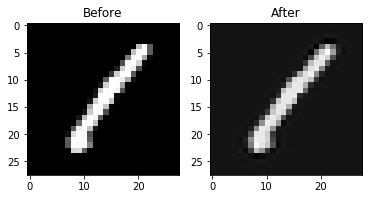

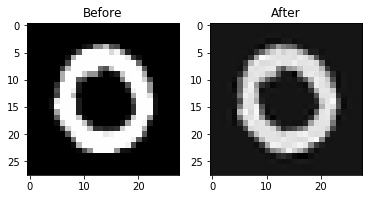

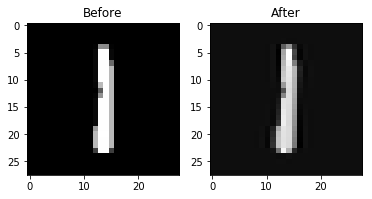

In [207]:
train_data_rotated = []

def show_two_images(X1, X2):
    fig = plt.figure()
    
    sub_plot = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(X1)
    sub_plot.set_title('Before')
    
    sub_plot = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(X2)
    sub_plot.set_title('After')
    
    plt.show()

for i, row in train_data.iterrows():
    label = row[0]
    X = row[1:].values.reshape(IMAGE_SIZE, IMAGE_SIZE)
    
    angle = np.random.randint(0, 8) if label == 1 or label == 7 else np.random.randint(0, 15)        
    angle *= random.choice([-1, 1])
    X_rotated = nd.rotate(X, angle, reshape=False)
    
    if i < 3:
        show_two_images(X, X_rotated)
    
    train_data_rotated.append([label] + np.reshape(X_rotated, IMAGE_SIZE * IMAGE_SIZE))
    
pd.DataFrame(train_data_rotated).to_csv('./data/train_rotated.csv', index=False, header=False)

*TODO*:

* normalize images, remove values like 263 etc, have thresholds like 0 and 1 for example or [-1.0, 1.0]
* add flipped/mirrored dataset ?
* add scaled dataset (10, 12, 14, 16, 18, 20 ...)

Let's shear the images (checkout [PIL Image documentation](http://effbot.org/imagingbook/image.htm) on Affine transformations): 

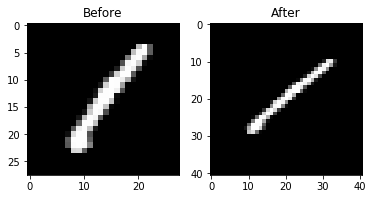

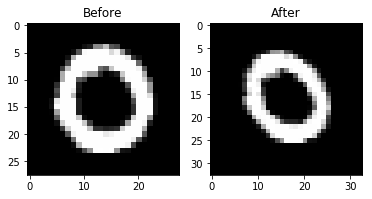

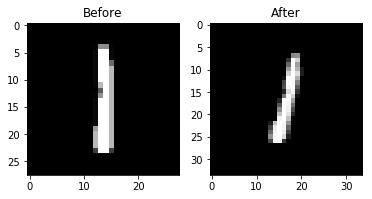

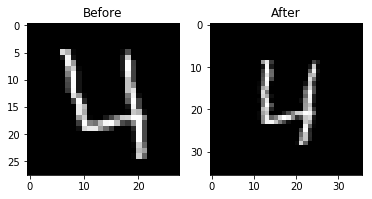

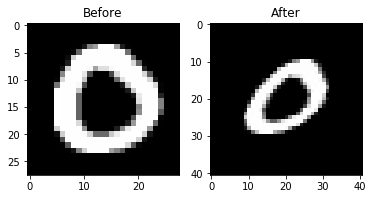

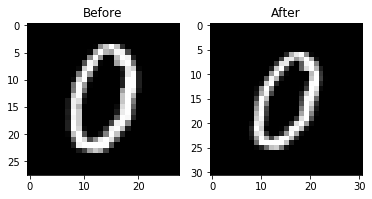

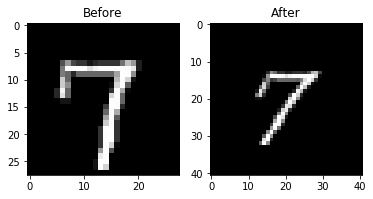

In [200]:
from PIL import Image

train_data_sheared = []

def square_sheared_image(img, size):
    new_square_size = max(img.size)
    new_square = np.zeros((new_square_size, new_square_size))    
    
    w, h = img.size
    offset = (round((new_square_size - w) / 2), round((new_square_size - h) / 2))
    
    new_square_img = Image.fromarray(np.uint8(new_square))    
    
    new_square_img.paste(img, offset)
    new_square_img.resize((size, size), resample=PIL.Image.BILINEAR)
    
    return new_square_img

for i, row in train_data.iterrows():
    label = row[0]
    X = row[1:].values.reshape(IMAGE_SIZE, IMAGE_SIZE)
        
    X_img = Image.fromarray(np.uint8(X))
    
    m = np.random.ranf() - 0.5
    xshift = abs(m) * IMAGE_SIZE
    new_width = IMAGE_SIZE + int(round(xshift))
    
    X_sheared = X_img.transform((new_width, IMAGE_SIZE), Image.AFFINE, (1, m, -xshift if m > 0 else 0, 0, 1, 0), Image.BICUBIC)
    X_sheared = square_sheared_image(X_sheared, IMAGE_SIZE)
            
    if i < 7:
        show_two_images(X, X_sheared)
        
    train_data_sheared.append([label] + np.reshape(new_square, IMAGE_SIZE * IMAGE_SIZE))
    
pd.DataFrame(train_data_sheared).to_csv('./data/train_sheared.csv', index=False, header=False)

Let's create elastic deformations by following procedure described [here](http://stackoverflow.com/questions/39308301/expand-mnist-elastic-deformations-matlab):

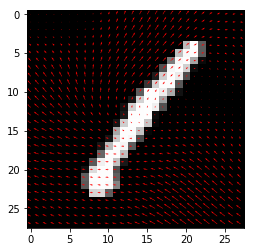

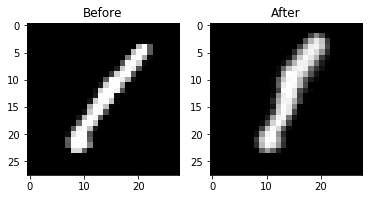

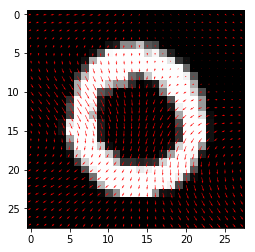

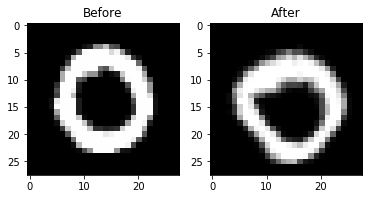

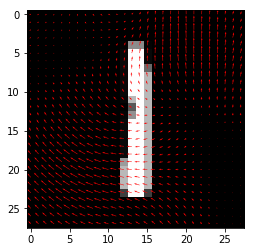

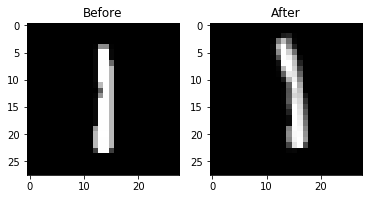

In [454]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

train_data_elastic_deformed = []

for i, row in train_data.iterrows():
    label = row[0]
    X = row[1:].values.reshape(IMAGE_SIZE, IMAGE_SIZE)
    
    sigma = 5
    alpha = 35
    
    rand_x = np.round(-1 + 2 * np.random.rand(IMAGE_SIZE, IMAGE_SIZE)); 
    rand_y = np.round(-1 + 2 * np.random.rand(IMAGE_SIZE, IMAGE_SIZE)); 
    
    dx = gaussian_filter(rand_x, sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter(rand_y, sigma, mode="constant", cval=0) * alpha

    x, y = numpy.meshgrid(numpy.arange(X.shape[0]), numpy.arange(X.shape[1]))
    indices = numpy.reshape(y + dy, (-1, 1)), numpy.reshape(x + dx, (-1, 1))

    X_deformed = map_coordinates(X, indices, order = 1).reshape(X.shape)      
    
    if i < 3:
        fig = plt.figure()
        plt.imshow(X)
        plt.quiver(dx, dy, color='r')
        plt.show()        
        show_two_images(X, X_deformed)
    
    train_data_elastic_deformed.append([label] + np.reshape(X_deformed, IMAGE_SIZE * IMAGE_SIZE))
    
pd.DataFrame(train_data_elastic_deformed).to_csv('./data/train_deformed.csv', index=False, header=False)